In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

SHOW_GIFS = False

In [2]:
import functions as fn
import execution as pso
import strategies
import plotting

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


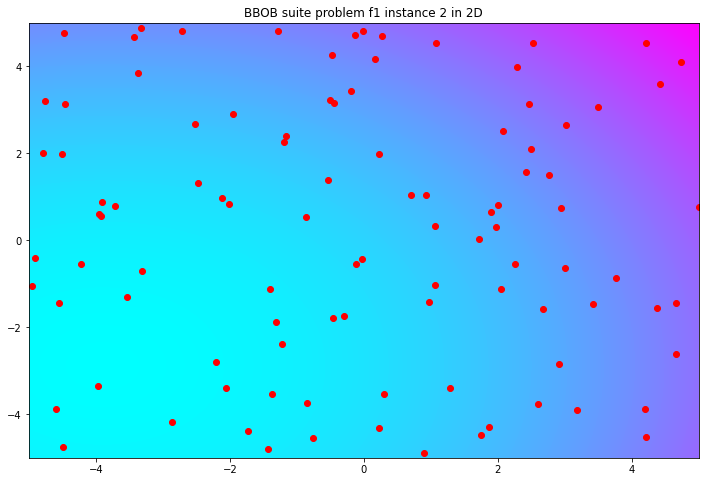

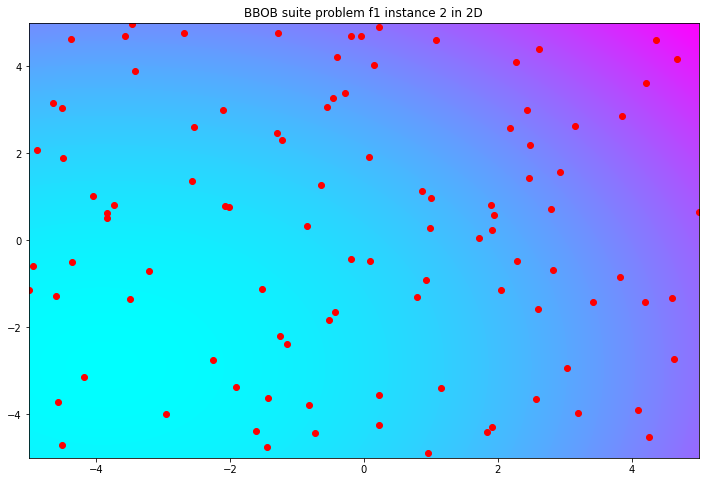

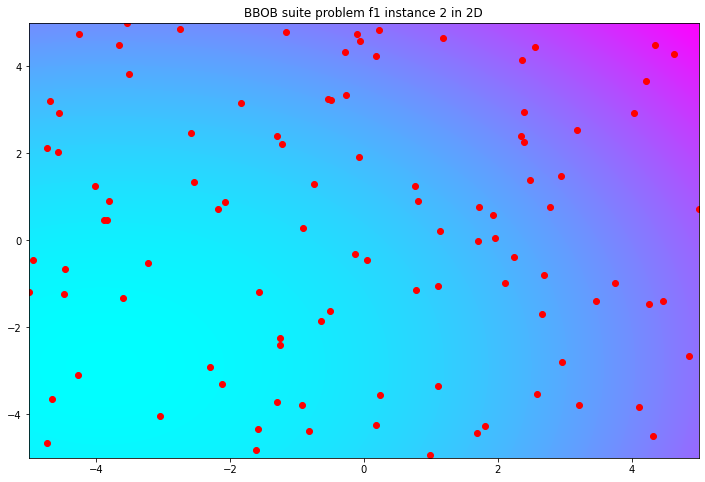

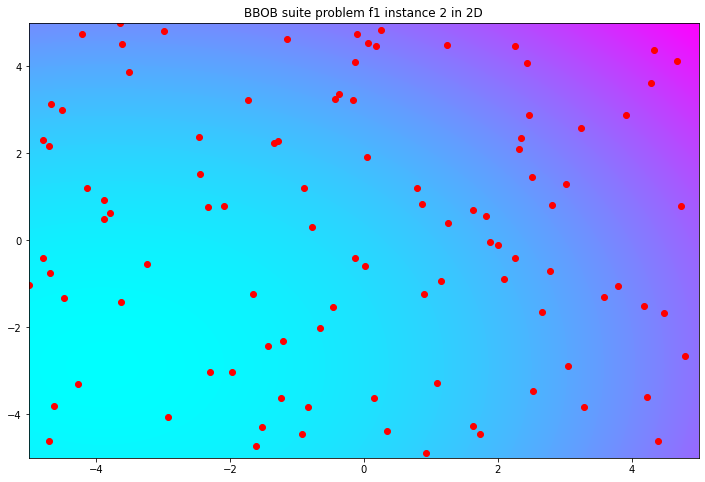

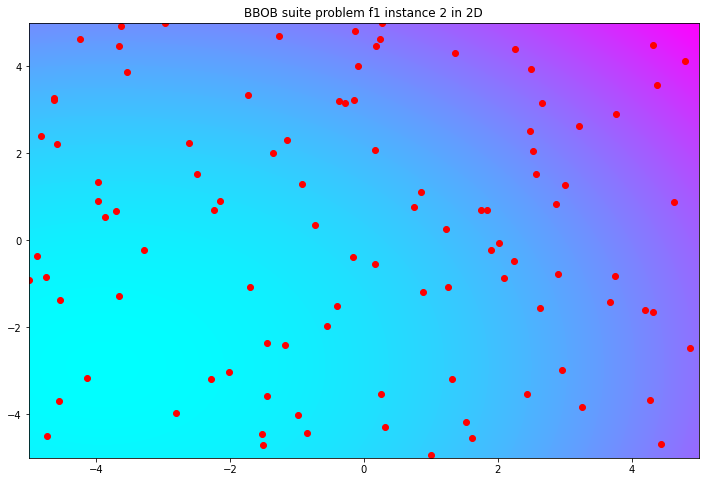

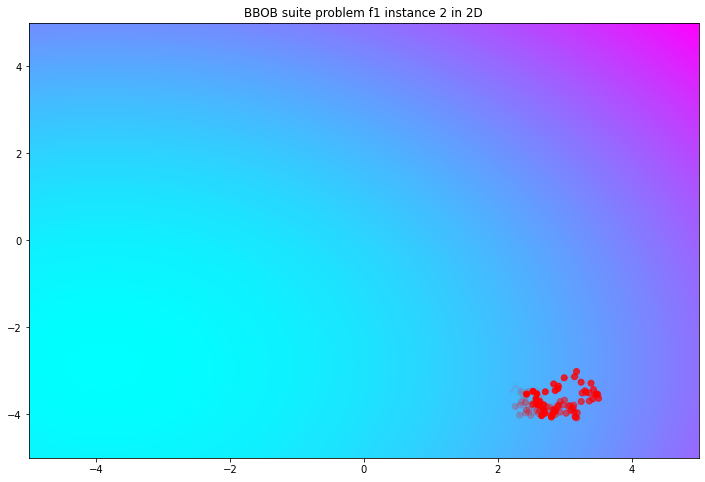

In [3]:
with fn.get_functions(dimension=[2], function_indices=[1]) as suite:
    for function in suite:  # type: fn.cocoex.Problem
        populations, values = pso.execute(
            function,
            strategies.random_walk,
            show_progress=True
        )
        
        plotting.plot_population(function, populations[-5])
        plotting.plot_population(function, populations[-4])
        plotting.plot_population(function, populations[-3])
        plotting.plot_population(function, populations[-2])
        plotting.plot_population(function, populations[-1])

        plotting.plot_movement_of_individual(function, populations[:,5,:])

        if SHOW_GIFS: 
            gif = plotting.animate_movement(function, populations, figsize=(12,8))
            display.Image(data=gif, format='png')
